## ROI segmentation

Our images come from a compact digital camera that captures the arm of the patient with the whole background of the environment. We need to select a ROI to perform the image processing techniques required for the vein segmentation. The most logical and fastest method is to display a red square with the ROI that the nurse will fit to the patient's arm. The area inside of that red square will be what we will be working with for the rest of the project.

In [1]:
import cv2
from matplotlib import pyplot as plt
from scipy.signal.signaltools import wiener
import numpy as np
from PIL import Image, ImageDraw
from scipy.signal.signaltools import wiener
import PIL
import glob

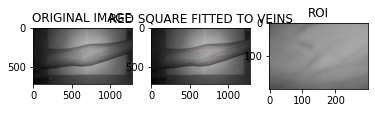

In [2]:
img = cv2.imread('../veins_db/forearm/forearm9.JPG')
width = img.shape[1]
height = img.shape[0]
range_x = [int(width/2 - 150), int(width/2 + 150)]
range_y = [int(height/2-100),int(height/2+100)]
roi = img[range_y[0]: range_y[1],range_x[0]:range_x[1]]
img_pil = PIL.Image.open('../veins_db/forearm/forearm9.JPG')
draw = ImageDraw.Draw(img_pil)
draw = draw.rectangle([(range_x[0],range_y[0]), (range_x[1],range_y[1])], outline ="red" )
fig, axs = plt.subplots(1,3)
axs[0].title.set_text('ORIGINAL IMAGE')
axs[0].imshow(img)
axs[1].title.set_text('RED SQUARE FITTED TO VEINS')
axs[1].imshow(img_pil)
axs[2].title.set_text('ROI')
axs[2].imshow(roi)

# 1st approach: Histogram equalization, OTSU and morphological operations

Our first approach will consist in applying tradition image processing techniques to segment the darker tone of the veins from the skin. We will try to perform the following steps:

1. CLAHE: An adaptive histogram equalization technique used to improve contrast in the images.It differs from ordinary histogram equalization in the respect that the adaptive method computes several histograms, each corresponding to a distinct section of the image, and uses them to redistribute the lightness values of the image.


2. Filtering: we will try with median, gaussian and other type of filters.


3. OTSU binarization: binarization with the objective of segmenting by binarizing the veins (black) and the skin (white).


4. Morphological operations: to skeletonize to the real width of the veins and trying to remove residual noise from the previous image processing techniques.

### We load all our previously chosen ROI images.

In [3]:
#LOAD IMAGES
images = []
filenames = []
for filename in glob.glob('../veins_db/cropped_all/*'):
    images.append(cv2.imread(filename))
    filenames.append(filename)

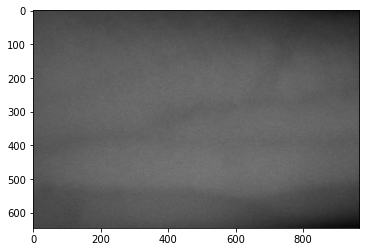

In [4]:
img = images[2]
plt.imshow(img, cmap = 'gray')

## 1.1 CLAHE (adaptive histogram equalization)

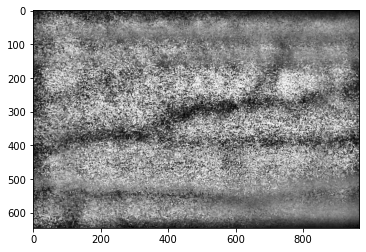

In [5]:
lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab_img)
clahe1 = cv2.createCLAHE(clipLimit=25.0, tileGridSize=(9, 9))
clahe1_img = clahe1.apply(l)
updated_lab_img21 = cv2.merge((clahe1_img, a, b))
lab_img = cv2.cvtColor(updated_lab_img21, cv2.COLOR_LAB2BGR)
lab_img = cv2.cvtColor(lab_img, cv2.COLOR_BGR2GRAY)
plt.imshow(lab_img, cmap = 'gray')

## 1.2 Image filtering

C:\Users\eduma\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1598: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
C:\Users\eduma\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1598: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


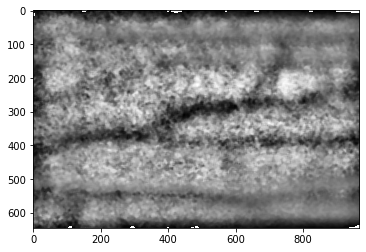

In [6]:
#MEDIAN FILTER
median = cv2.medianBlur(lab_img, 9)
#GAUSSIAN FILTER
gblur = cv2.GaussianBlur(median, (3, 3), 0.5)
#WEINER FILTER (DEBLURRING)
filtered_img = wiener(gblur, (1, 1))
plt.imshow(filtered_img, cmap = 'gray')

## 1.3 OTSU binarization

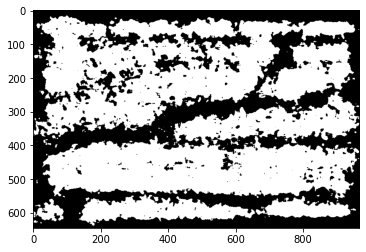

In [7]:
#OTSU BINARIZATION
filtered_img=filtered_img.astype("uint8")
ret2,otsu = cv2.threshold(filtered_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(otsu, cmap = 'gray')

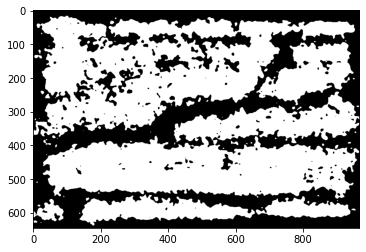

In [8]:
#MEDIAN FILTER SECOND TIME
median2 = cv2.medianBlur(otsu, 5)
plt.imshow(median2, cmap = 'gray')

## 1.4 Morphological operations

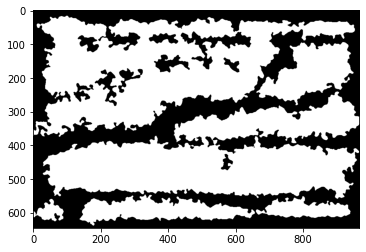

In [34]:
from MIA_utils.APPROACH1 import despeckle


# DESPECKLE BLACK
inverted = cv2.bitwise_not(median2);
mask = cv2.bitwise_not(despeckle(inverted, 500));

# DESPECKLE WHITE
mask = despeckle(mask, 500);
plt.imshow(mask, cmap='gray')

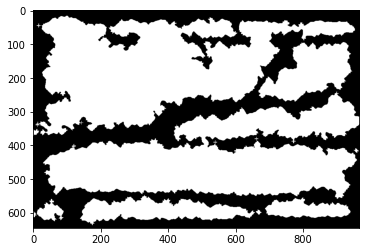

In [31]:
element = cv2.getStructuringElement(cv2.MORPH_CROSS, (11,11))
dilate = cv2.morphologyEx(mask, cv2.MORPH_OPEN, element)
plt.imshow(dilate, cmap = 'gray')

# 2nd approach: Histogram equalization and KNN

In [ ]:
img = images[2]
plt.imshow(img, cmap = 'gray')

## 2.1 CLAHE (adaptive histogram equalization)

In [ ]:
lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab_img)
clahe1 = cv2.createCLAHE(clipLimit=25.0, tileGridSize=(9, 9))
clahe1_img = clahe1.apply(l)
updated_lab_img21 = cv2.merge((clahe1_img, a, b))
lab_img = cv2.cvtColor(updated_lab_img21, cv2.COLOR_LAB2BGR)
lab_img = cv2.cvtColor(lab_img, cv2.COLOR_BGR2GRAY)
plt.imshow(lab_img, cmap = 'gray')

## 2.2 KNN

In [ ]:
# reshape the image to a 2D array of pixels and 3 color values (RGB)
pixel_values = lab_img.reshape((-1, 3))
# convert to float
pixel_values = np.float32(pixel_values)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

k = 2
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# convert back to 8 bit values
centers = np.uint8(centers)

# flatten the labels array
labels = labels.flatten()
segmented_image = centers[labels.flatten()]

# reshape back to the original image dimension
segmented_image = segmented_image.reshape(lab_img.shape)
plt.imshow(segmented_image, cmap = 'gray')

In [ ]:
segmented_image=cv2.medianBlur(segmented_image, 11)
# draw contours on the original image
ret, thresh = cv2.threshold(segmented_image, 100, 255, cv2.THRESH_BINARY)

# detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

#contours, hierarchy = cv2.findContours(thesh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# draw all contours
image = cv2.drawContours(img, contours, -1, (255, 0, 0),2)
plt.imshow(image)